# NAO analysis in FOCI-OpenIFS AGRIF

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cmocean 
from eofs.xarray import Eof

In [2]:
#pip install eofs

Note: you may need to restart the kernel to use updated packages.


In [29]:
def calculate_eof(da_msl, neofs=1, npcs=10):
    # First remove seasonal cycle
    da_msl_anom = da_msl.groupby('time.month') - da_msl.groupby('time.month').mean('time')
    
    # We need weights for grid area
    #weights = np.tile( np.cos(np.deg2rad(da_msl_anom['lat'].values)), (da_msl_anom['lon'].shape[0],1) ).T
    coslat = np.cos(np.deg2rad(da_msl_anom.coords['lat'].values)).clip(0., 1.)
    weights = np.sqrt(coslat)[..., np.newaxis]
    
    # calculate EOF and PC
    #solver = Eof(da_msl_anom.values, weights = weights)
    solver = Eof(da_msl_anom, weights=weights)
    eofs   = solver.eofs(neofs = neofs)
    #eofs   = solver.eofsAsCovariance(neofs=neofs)
    pcs    = solver.pcs(npcs = npcs)
    
    # get explained variances
    explained_variance = solver.varianceFraction(neigs=10)
    
    # Put data in DataArray
    da_eofs = xr.DataArray(eofs, dims=("eof", "lat", "lon"), coords={"lon": da_msl['lon'], "lat": da_msl['lat'], "eof": np.arange(1,neofs+1)})
    da_pcs  = xr.DataArray(pcs,  dims=("time", "eof"), coords={"time": da_msl['time'], "eof": np.arange(1,npcs+1)})
    
    return da_eofs, da_pcs

## Sea-level pressure data

In [30]:
# FOCI-LR
foci_lr = '/sfs/fs1/work-geomar/smomw352/foci_analysis/foci_JJK001_pmpi_1m_19500101_19791231_GG_surface_r360x180_180.nc'
ds_foci_lr = xr.open_dataset(foci_lr)
msl_foci_lr = ds_foci_lr['MSL']
na_msl_foci_lr = msl_foci_lr.sel(lon=slice(-90,40),lat=slice(20,80))
eof_msl_foci_lr, pc_msl_foci_lr = calculate_eof(na_msl_foci_lr)

# FOCI-LR-NEST
foci_lr_nest = '/sfs/fs1/work-geomar/smomw352/foci_analysis/foci_JJK002_29_1m_19500101_19791231_GG_surface_r360x180_180.nc'
ds_foci_lr_nest = xr.open_dataset(foci_lr_nest)
msl_foci_lr_nest = ds_foci_lr_nest['MSL']
na_msl_foci_lr_nest = msl_foci_lr_nest.sel(lon=slice(-90,40),lat=slice(20,80))
eof_msl_foci_lr_nest, pc_msl_foci_lr_nest = calculate_eof(na_msl_foci_lr_nest)

# FOCI-HR-NEST
foci_hr_nest = '/sfs/fs1/work-geomar/smomw352/foci_analysis/foci_JJK005_6_1m_19500101_19791231_GG_surface_r360x180_180.nc'
ds_foci_hr_nest = xr.open_dataset(foci_hr_nest)
msl_foci_hr_nest = ds_foci_hr_nest['MSL']
na_msl_foci_hr_nest = msl_foci_hr_nest.sel(lon=slice(-90,40),lat=slice(20,80))
eof_msl_foci_hr_nest, pc_msl_foci_hr_nest = calculate_eof(na_msl_foci_hr_nest)

# FOCI-HR
foci_hr = '/sfs/fs1/work-geomar/smomw352/foci_analysis/foci_JJK006_3_1m_19500101_19791231_GG_surface_r360x180_180.nc'
ds_foci_hr = xr.open_dataset(foci_hr)
msl_foci_hr = ds_foci_hr['MSL']
na_msl_foci_hr = msl_foci_hr.sel(lon=slice(-90,40),lat=slice(20,80))
eof_msl_foci_hr, pc_msl_foci_hr = calculate_eof(na_msl_foci_hr)

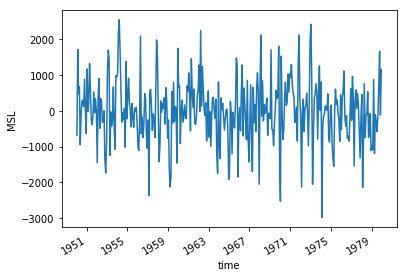

In [31]:
fig, ax = plt.subplots(1,1)

msl_lr_anom = na_msl_foci_lr.groupby('time.month') - na_msl_foci_lr.groupby('time.month').mean('time')
# Reykjavik: 64.1466° N, 21.9426° W
rey_msl_lr = msl_lr_anom.sel(lon = [-21.9426], lat = [64.1466], method="nearest").squeeze()
# Lisbon: 38.7253° N, 9.15° W
lis_msl_lr = msl_lr_anom.sel(lon = [-9.15], lat = [38.7253], method="nearest").squeeze()
(lis_msl_lr - rey_msl_lr).plot(ax=ax)

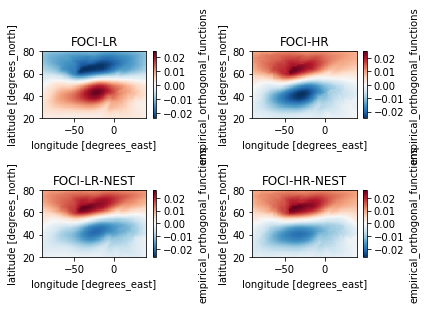

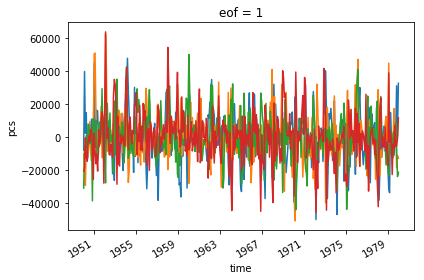

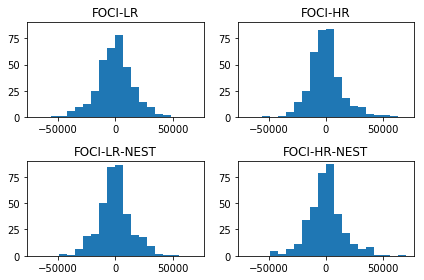

In [34]:
# Plot North Atlantic EOF
fig1, axes = plt.subplots(2,2)
axs = axes.flat
eof_msl_foci_lr.sel(eof=1).plot(ax=axs[0])
eof_msl_foci_hr.sel(eof=1).plot(ax=axs[1])
eof_msl_foci_lr_nest.sel(eof=1).plot(ax=axs[2])
eof_msl_foci_hr_nest.sel(eof=1).plot(ax=axs[3])
axs[0].set_title('FOCI-LR')
axs[1].set_title('FOCI-HR')
axs[2].set_title('FOCI-LR-NEST')
axs[3].set_title('FOCI-HR-NEST')
fig1.tight_layout()

fig2, axs = plt.subplots(1,1)
pc_msl_foci_lr.sel(eof=1).plot(ax=axs,label='FOCI-LR')
pc_msl_foci_hr.sel(eof=1).plot(ax=axs,label='FOCI-HR')
pc_msl_foci_lr_nest.sel(eof=1).plot(ax=axs,label='FOCI-LR-NEST')
pc_msl_foci_hr_nest.sel(eof=1).plot(ax=axs,label='FOCI-HR-NEST')
fig2.tight_layout()

fig3, axes = plt.subplots(2,2)
axs = axes.flat
bins = np.linspace(-7,7,21) * 1e4
axs[0].set_title('FOCI-LR')
axs[0].hist(pc_msl_foci_lr.sel(eof=1).values,bins=bins)
axs[1].set_title('FOCI-HR')
axs[1].hist(pc_msl_foci_hr.sel(eof=1).values,bins=bins)
axs[2].set_title('FOCI-LR-NEST')
axs[2].hist(pc_msl_foci_lr_nest.sel(eof=1).values,bins=bins)
axs[3].set_title('FOCI-HR-NEST')
axs[3].hist(pc_msl_foci_hr_nest.sel(eof=1).values,bins=bins)
for ax in axs:
    ax.set_ylim([0,90])
fig3.tight_layout()